### Concat all HIBP and Analyze

In [1]:
import glob
import os
import re
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
# Directory path containing JSON files
directory = 'pwned/'

logging.basicConfig(filename='error_log_read_json.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Get list of JSON file paths in the directory
json_files = glob.glob(directory + '/*.json')

# Define a function for processing a JSON file
def process_json_file(file):
    try:
        df = pd.read_json(file)
        file_name = os.path.basename(file).rstrip('.json')
        df['email'] = file_name
        return df
    except ValueError as e:
        logging.error(f"Error reading file: {file}. Error message: {e}")
        return None

# Create a pool of worker processes
pool = Pool()

# Create a progress bar with tqdm
progress_bar = tqdm(total=len(json_files), desc="Processing JSON files", unit="file")

# Process JSON files in parallel
results = []
for df in pool.imap_unordered(process_json_file, json_files):
    results.append(df)
    progress_bar.update(1)

# Close the pool of worker processes
pool.close()
pool.join()

# Close the progress bar
progress_bar.close()

Processing JSON files: 100%|████████████████████████████████████████████████████████████████████████████████████| 1162292/1162292 [25:25<00:00, 761.83file/s]


In [3]:
# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)
del results

In [4]:
breaches = pd.read_json('data/breaches.json')

In [5]:
breached_email_df = pd.merge(combined_df, breaches, on='Name')
breached_email_df.shape

(8643150, 17)

### Let's create an email level dataset for which we have breaches

#### Non-fab
https://haveibeenpwned.com/FAQs#FabricatedBreach

In [6]:
breached_email_df['non_fab'] = ~breached_email_df['IsFabricated'].fillna(1)

#### Serious Dataclasses Breached 
Either data that will help you hack your other accounts, e.g., Mother's Maiden Name, or sensitive personal information

In [7]:
serious_dataclasses = ["Audio recordings",
"Auth tokens", #account cracking
"Bank account numbers",
"Biometric data",
"Browsing histories",
"Chat logs",
"Credit card CVV", #fin
"Credit cards", #fin
#"Credit status information", # don't know what this means
"Drinking habits",
"Driver's licenses",
"Drug habits",
"Email messages",
"Encrypted keys", #account cracking
"Government issued IDs",
#"Health insurance information",
"Historical passwords", #account cracking
"HIV statuses",
#"Mothers maiden names", #account cracking
"Partial credit card data", #fin
"Passport numbers",
"Password hints",
"Passwords", #account cracking
"Personal health data",
"Photos",
"PINs", #account cracking
"Places of birth", #account cracking
"Private messages",
"Security questions and answers", #account cracking
"Sexual fetishes",
"Sexual orientations",
"SMS messages",
"Social security numbers",
"Taxation records"]

In [8]:
breached_email_df['serious'] = breached_email_df['DataClasses'].apply(lambda x: any(string in x for string in serious_dataclasses))

In [9]:
br_email_df = breached_email_df.assign(count=1).\
    groupby('email').\
    agg(total_breaches = ('count', 'sum'),
    serious_breaches   = ('serious', 'sum'),
    non_fab_breaches   = ('non_fab', 'sum'),
    non_null_uniques   = ('Name', 'nunique')
).reset_index()

### Join to Valid Email List

In [10]:
valid_emails = pd.read_csv("data/fl_valid_emails.csv")
# can also do less strict is_valid_email
valid_emails = valid_emails[valid_emails['is_valid_email_dns'] == True] 

In [11]:
# Merge breaches to parsed
valid_emails['email'] = valid_emails['email'].str.lower()
br_email_df['email']  = br_email_df['email'].str.lower()
fin_df = pd.merge(valid_emails, br_email_df, how = 'left', on = 'email')

In [12]:
fin_df.fillna({'total_breaches': 0, 
               'serious_breaches': 0,
               'non_fab_breaches': 0,
               'non_null_uniques': 0}, inplace = True)

In [13]:
fin_df[['total_breaches', 'serious_breaches', 'non_fab_breaches', 'non_null_uniques']].describe().round(1)

,total_breaches,serious_breaches,non_fab_breaches,non_null_uniques
count,1348186.0,1348186.0,1348186.0,1348186.0
mean,6.2,3.7,6.2,6.2
std,5.9,3.9,5.9,5.9
min,0.0,0.0,0.0,0.0
25%,1.0,1.0,1.0,1.0
50%,5.0,3.0,5.0,5.0
75%,10.0,6.0,10.0,10.0
max,390.0,333.0,389.0,390.0


In [14]:
fin_df[['total_breaches', 'serious_breaches', 'non_fab_breaches', 'non_null_uniques']].describe().to_markdown()

'|       |   total_breaches |   serious_breaches |   non_fab_breaches |   non_null_uniques |\n|:------|-----------------:|-------------------:|-------------------:|-------------------:|\n| count |      1.34819e+06 |        1.34819e+06 |        1.34819e+06 |        1.34819e+06 |\n| mean  |      6.22427     |        3.65431     |        6.22425     |        6.22427     |\n| std   |      5.865       |        3.90145     |        5.86484     |        5.865       |\n| min   |      0           |        0           |        0           |        0           |\n| 25%   |      1           |        1           |        1           |        1           |\n| 50%   |      5           |        3           |        5           |        5           |\n| 75%   |     10           |        6           |       10           |       10           |\n| max   |    390           |      333           |      389           |      390           |'

In [15]:
(fin_df['total_breaches'] > 0).mean()

0.8392714358404553

### Digital Gap: Sociodemographic Predictors of Breaches

In [16]:
def calculate_summary_statistics(data_df, groupby_column, value_column, percentiles=None):
    """
    Calculate summary statistics for a given DataFrame.

    Parameters:
        data_df (DataFrame): The DataFrame containing the data.
        groupby_column (str): The column to group by.
        value_column (str): The column for which to calculate statistics.
        percentiles (list, optional): List of percentiles to calculate. Default is None.

    Returns:
        DataFrame: A DataFrame with the summary statistics.
    """
    if percentiles is None:
        percentiles = [25, 50, 75]

    # Calculate summary statistics
    summary_stats = data_df.groupby(groupby_column)[value_column].agg(['count', 'mean', 'std', 'min', 'max']).round(1)

    # Calculate percentile values
    percentile_values = data_df.groupby(groupby_column)[value_column].apply(lambda x: pd.Series(np.nanpercentile(x, percentiles), index=percentiles)).unstack().round(1)

    # Merge summary statistics and percentile values
    summary_with_percentiles = pd.merge(summary_stats, percentile_values, left_index=True, right_index=True)

    # Reorder columns
    desired_columns = ['count', 'mean', 'std', 'min'] + percentiles + ['max']
    summary_with_percentiles = summary_with_percentiles.reindex(columns=desired_columns).reset_index()

    return summary_with_percentiles

In [17]:
gen_sum = calculate_summary_statistics(fin_df, 
                                   groupby_column='gender', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75])
print(gen_sum)

  gender   count  mean  std  min   25   50    75    max
0      F  721828   6.4  5.8  0.0  2.0  5.0  10.0  157.0
1      M  605040   6.0  5.9  0.0  1.0  5.0   9.0  390.0
2      U   21296   4.8  6.0  0.0  0.0  3.0   7.0  265.0


In [18]:
gen_sum.to_markdown()

'|    | gender   |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|---:|:---------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n|  0 | F        |  721828 |    6.4 |   5.8 |     0 |    2 |    5 |   10 |   157 |\n|  1 | M        |  605040 |    6   |   5.9 |     0 |    1 |    5 |    9 |   390 |\n|  2 | U        |   21296 |    4.8 |   6   |     0 |    0 |    3 |    7 |   265 |'

In [19]:
race_sum = calculate_summary_statistics(fin_df, 
                                   groupby_column='race_lit', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75])
print(race_sum)

           race_lit   count  mean  std  min   25   50    75    max
0             Asian   30518   5.9  5.8  0.0  1.0  4.0   9.0  154.0
1          Hispanic  317399   5.8  5.7  0.0  1.0  4.0   9.0  210.0
2      Multi-Racial   10046   5.7  5.8  0.0  1.0  4.0   9.0  145.0
3          NH Black  184947   5.8  5.7  0.0  1.0  5.0   9.0  265.0
4          NH White  750527   6.5  6.0  0.0  2.0  5.0  10.0  390.0
5  Native Americans    3764   5.8  5.7  0.0  1.0  4.0   9.0   42.0
6             Other   27028   6.2  5.9  0.0  1.0  5.0   9.0  123.0
7           Unknown   23957   5.3  5.6  0.0  1.0  4.0   8.0  195.0


In [20]:
race_sum.to_markdown()

'|    | race_lit         |   count |   mean |   std |   min |   25 |   50 |   75 |   max |\n|---:|:-----------------|--------:|-------:|------:|------:|-----:|-----:|-----:|------:|\n|  0 | Asian            |   30518 |    5.9 |   5.8 |     0 |    1 |    4 |    9 |   154 |\n|  1 | Hispanic         |  317399 |    5.8 |   5.7 |     0 |    1 |    4 |    9 |   210 |\n|  2 | Multi-Racial     |   10046 |    5.7 |   5.8 |     0 |    1 |    4 |    9 |   145 |\n|  3 | NH Black         |  184947 |    5.8 |   5.7 |     0 |    1 |    5 |    9 |   265 |\n|  4 | NH White         |  750527 |    6.5 |   6   |     0 |    2 |    5 |   10 |   390 |\n|  5 | Native Americans |    3764 |    5.8 |   5.7 |     0 |    1 |    4 |    9 |    42 |\n|  6 | Other            |   27028 |    6.2 |   5.9 |     0 |    1 |    5 |    9 |   123 |\n|  7 | Unknown          |   23957 |    5.3 |   5.6 |     0 |    1 |    4 |    8 |   195 |'

In [21]:
# Recode Age

fin_df['age'] = 2022 - pd.to_datetime(fin_df['birth_yr'], format='%m/%d/%Y').dt.year
age_buckets = [0, 25, 50, 65, 120]
labels = ['<25', '25--50', '50--65', '65+'] 

fin_df['age_lab'] = pd.cut(fin_df['age'], bins = age_buckets, labels = labels)
fin_df['age_lab'].value_counts()

age_lab
25--50    596147
50--65    330168
65+       255495
<25       166376
Name: count, dtype: int64

In [22]:
print(calculate_summary_statistics(fin_df, 
                                   groupby_column='age_lab', 
                                   value_column='total_breaches',
                                   percentiles = [25, 50, 75]))

  age_lab   count  mean  std  min   25   50    75    max
0     <25  166376   4.6  4.9  0.0  1.0  3.0   7.0  265.0
1  25--50  596147   6.6  5.9  0.0  2.0  5.0  10.0  390.0
2  50--65  330168   6.6  6.1  0.0  2.0  5.0  10.0  210.0
3     65+  255495   5.8  5.7  0.0  1.0  4.0   9.0  234.0


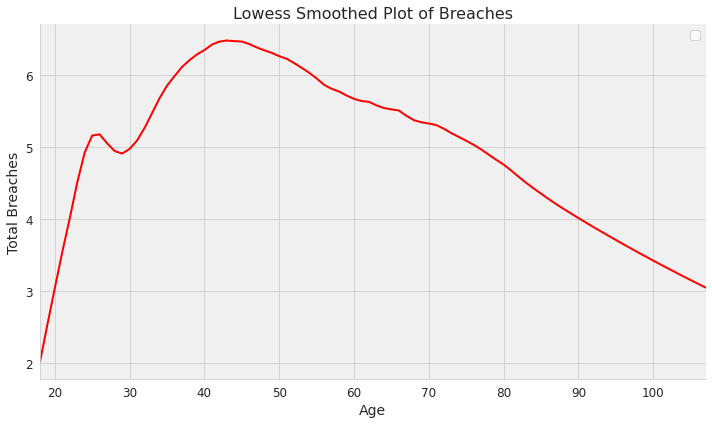

In [27]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import MultipleLocator

lowess = sm.nonparametric.lowess

lowess_model = lowess(fin_df['total_breaches'], fin_df['age'], frac=0.07)

# Create the plot using seaborn and matplotlib
sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(10, 6))
plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='red', linewidth=2)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Total Breaches', fontsize=14)
plt.title('Lowess Smoothed Plot of Breaches', fontsize=16)
plt.legend(fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().xaxis.set_major_locator(MultipleLocator(base=10))
plt.xlim(min(fin_df['age']), max(fin_df['age']))

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.tight_layout()

plt.savefig('figs/age_breaches.png', dpi=300)
plt.show()

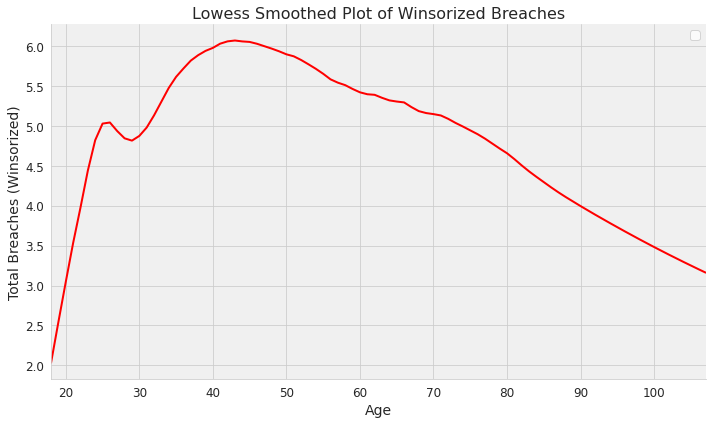

In [26]:
# Let's winsorize or we can lowess over medians
from scipy.stats.mstats import winsorize
winsorized_breaches = winsorize(fin_df['total_breaches'], limits=(0.0, 0.2))

lowess_model = lowess(winsorized_breaches, fin_df['age'], frac=0.07)

# Create the plot using seaborn and matplotlib
sns.set_style("whitegrid")  # Set the plot style
plt.figure(figsize=(10, 6))
plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='red', linewidth=2)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Total Breaches (Winsorized)', fontsize=14)
plt.title('Lowess Smoothed Plot of Winsorized Breaches', fontsize=16)
plt.legend(fontsize=12)

# Adjust tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().xaxis.set_major_locator(MultipleLocator(base=10))
plt.xlim(min(fin_df['age']), max(fin_df['age']))

# Add a light gray background to the plot
plt.gca().set_facecolor('#f0f0f0')

# Remove right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.tight_layout()

plt.savefig('figs/age_winsorized_breaches.png', dpi=300)
plt.show()